### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

##### Будем смотреть на k-той итерации

1) MSE: $-\dfrac{\partial MSE}{\partial F}(F_{k-1}(x_i), y_i)=  -2*(F_{k-1}(x_i) - y_i) $

2) Экспоненциальная: $ -\dfrac{\partial}{\partial F}exp(-F_{k-1}(x_i) y_i)=-\exp(-y_i F_{k-1}(x_i))(-y_i) =  y_i*\exp(-y_i F_{k-1}(x_i))$

3) Логистическая: $ -\dfrac{\partial L}{\partial}(\log (1 + exp( -F_{k-1}(x_i) y_i))) = \dfrac{y_i*\exp(-y_i F_{k-1}(x_i))}{1 + \exp(-y_i F_{k-1}(x_i)} = \dfrac{y_i}{1 + \exp(y_i F_{k-1}(x_i))}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [13]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [14]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.fitted = []
        self.feats = []
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        
        if init_model is None:
            self.in_pr = np.zeros_like(y).astype('float64')
        else:
            init_model.fit(X,y)
            self.in_pr = init_model.predict(X).astype('float64')
            self.fitted.append(init_model)
            self.feats.append(np.arange(X.shape[1]))

        num_prizn = int(self.subsample * X.shape[0])
        num_features = int(self.colsample * X.shape[1])
        
        
        for step in range(self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            
            ind = np.random.choice(X.shape[0], num_prizn)
            features =  np.sort(np.random.choice(X.shape[1], num_features, replace=False))

            X_tr = X[ind][:, features]
            self.feats.append(features)

            last = self.in_pr[ind]
            y_tr = y[ind]
                                    
            if self.loss == 'MSE':
                delta = 2 * (y_tr - last)                        

            if self.loss == 'EXP':
                delta = y_tr * np.exp(-y_tr * last)

            if self.loss == 'LOG':
                delta = y_tr / (np.exp(y_tr * last) + 1.0)


            model.fit(X_tr, delta)
            self.in_pr += self.learning_rate * model.predict(X[:, features])
            self.fitted.append(model)
        
    def predict(self, X):
        N = X.shape[0]
        M = X.shape[1]
        a = np.tile(np.arange(N), M).reshape(-1,N).T
        b = np.tile(np.arange(M), N).reshape(-1,M)
        predict  = 0
        for ii, model in enumerate(self.fitted):
            predict += self.learning_rate * model.predict(X[:, self.feats[ii]])
        if self.loss == 'MSE':
            return (predict > 0.5).astype('int')
        if self.loss == 'EXP':
            return (predict > 0.5).astype('int')
        if self.loss == 'LOG':
            return (predict > 0.5).astype('int')

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [18]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [19]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [15]:
from sklearn.metrics import accuracy_score

In [16]:
import matplotlib.pyplot as plt

In [17]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [21]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
accur2 = []
for i in [1,2,3,5,7,10,15,20,30,40,50,70,100,150,200,350,500,750,1000]:
    alg = MyGradientBoostingClassifier(n_estimators=i)
    alg.fit(X_train, y_train)
    pred = alg.predict(X_test)
    accur2.append(accuracy_score(y_test, pred))

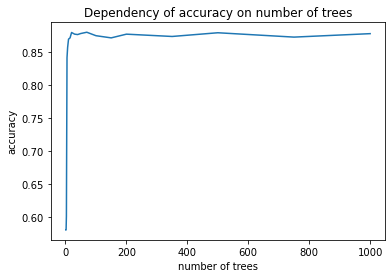

In [29]:
x = [1,2,3,5,7,10,15,20,30,40,50,70,100,150,200,350,500,750,1000]
plt.plot(x,accur2)
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.title("Dependency of accuracy on number of trees")
plt.show()

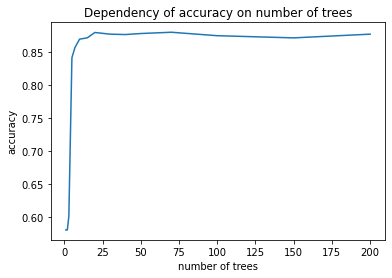

In [30]:
x = [1,2,3,5,7,10,15,20,30,40,50,70,100,150,200,350,500,750,1000]
plt.plot(x[:-4],accur2[:-4])
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.title("Dependency of accuracy on number of trees")
plt.show()

Видно, что после 30 итераций уже нет смысла увеличивать количество деревьев.

In [31]:
accur2 = []
for i in [0.001,0.01,0.05,0.1,0.2,0.3,0.5,0.7,0.8,0.9,1]:
    alg = MyGradientBoostingClassifier(n_estimators=30, learning_rate=i)
    alg.fit(X_train, y_train)
    pred = alg.predict(X_test)
    accur2.append(accuracy_score(y_test, pred))

In [32]:
accur2

[0.5800387596899225,
 0.5800387596899225,
 0.8848837209302326,
 0.8707364341085271,
 0.8505813953488373,
 0.8038759689922481,
 0.7054263565891473,
 0.08333333333333333,
 0.0011627906976744186,
 0.0,
 0.0]

best lr=0.05

In [35]:
accur2 = []
for i in [0.2,0.4,0.6,0.8,1.0]:
    alg = MyGradientBoostingClassifier(n_estimators=30, learning_rate=0.05,colsample=i)
    alg.fit(X_train, y_train)
    pred = alg.predict(X_test)
    accur2.append(accuracy_score(y_test, pred))

In [36]:
accur2 

[0.7401162790697674,
 0.8313953488372093,
 0.8625968992248062,
 0.8819767441860465,
 0.8817829457364341]

best colsample=0.8

Теперь, попробуем снова увеличить количество деревьев.

In [44]:
accur2 = []
for i in [0.2,0.4,0.6,0.8,1.0,1.2,1.4]:
    alg = MyGradientBoostingClassifier(n_estimators=30, learning_rate=0.05,colsample=0.8, subsample=i)
    alg.fit(X_train, y_train)
    pred = alg.predict(X_test)
    accur2.append(accuracy_score(y_test, pred))

In [45]:
accur2

[0.875,
 0.8866279069767442,
 0.890891472868217,
 0.8916666666666667,
 0.8833333333333333,
 0.8722868217054264,
 0.8748062015503876]

best subsample = 0.8

In [50]:
accur2 = []
for i in [2,3,5,7,9,13,15]:
    alg = MyGradientBoostingClassifier(n_estimators=30, learning_rate=0.05,colsample=0.8, subsample=0.8, max_depth=i)
    alg.fit(X_train, y_train)
    pred = alg.predict(X_test)
    accur2.append(accuracy_score(y_test, pred))

In [51]:
accur2

[0.8337209302325581,
 0.8443798449612403,
 0.8594961240310077,
 0.8833333333333333,
 0.8963178294573644,
 0.8920542635658915,
 0.8905038759689923]

best_depth = 7

In [56]:
alg = MyGradientBoostingClassifier(loss='MSE',n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train)
pred = alg.predict(X_test)
accuracy_score(y_test, pred)

0.890891472868217

In [77]:
alg = MyGradientBoostingClassifier(loss='EXP',n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train)
pred = alg.predict(X_test)
accuracy_score(y_test, pred)

0.8765503875968992

In [78]:
alg = MyGradientBoostingClassifier(loss='LOG',n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train)
pred = alg.predict(X_test)
accuracy_score(y_test, pred)

0.7887596899224806

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [83]:
alg = MyGradientBoostingClassifier(loss ='MSE', n_estimators=80,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, base_model=RandomForestRegressor)
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

0.8992248062015504

In [85]:
prs = np.zeros_like(y_test)
for i in range(1000):
    alg = MyGradientBoostingClassifier(loss ='MSE', n_estimators=50,
                                       learning_rate=0.05,colsample=0.8,
                                       subsample=0.8, max_depth=7)
    alg.fit(X_train, y_train)
    prs += alg.predict(X_test)

In [90]:
accuracy_score((prs/1000).astype('int'), y_test)

0.8527131782945736

Удалось немного увеличить качество в первой стратегии. Предположительно, это из-за того, что RandomForestRegressor более мощный алгоритм, чеб decision tree и лучше учится.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [19]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC

In [85]:
alg = MyGradientBoostingClassifier(loss ='EXP', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=LinearRegression())
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

0.7866279069767442

In [23]:
alg = MyGradientBoostingClassifier(loss ='EXP', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=LogisticRegression(max_iter=400))
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

0.664922480620155

In [72]:
alg = MyGradientBoostingClassifier(loss ='EXP', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=SVC(kernel='linear',max_iter=4000))
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

/home/chris/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


0.8664728682170543

In [65]:
alg = MyGradientBoostingClassifier(loss ='EXP', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=SVC(kernel='rbf',max_iter=20))
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

/home/chris/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


0.7451550387596899

In [75]:
alg = MyGradientBoostingClassifier(loss ='EXP', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=RandomForestRegressor())
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

0.5800387596899225

In [77]:
alg = MyGradientBoostingClassifier(loss ='MSE', n_estimators=30,
                                   learning_rate=0.05,colsample=0.8,
                                   subsample=0.8, max_depth=7)
alg.fit(X_train, y_train, init_model=RandomForestClassifier())
y_pred = alg.predict(X_test)
accuracy_score(y_pred, y_test)

0.5800387596899225

Точность здесь только падает. Возможно, это связано с тем, сто первык классификатор исправляет часть ошибок на тестовой выборке и далее остальные модели учатся слабее.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Все понятно, все хорошо!